In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import IPython.display as display
import time

from concurrent.futures import ThreadPoolExecutor

%matplotlib inline

ModuleNotFoundError: No module named 'tensorflow'

In [2]:
def get_files(root):
    PATHS = list()

    def parse_dir(root):
        if os.path.isfile(root):
            PATHS.append(root)
        elif os.path.isdir(root):
            for dirname in os.listdir(root):
                parse_dir(os.path.join(root, dirname))

    parse_dir(root)
    return PATHS

In [6]:
PATH_IMAGE = 'images'

PATHS = get_files(PATH_IMAGE)

In [9]:
PATHS

['images\\1\\1.png',
 'images\\1\\2.png',
 'images\\2\\1.png',
 'images\\2\\2.png',
 'images\\3\\1.png',
 'images\\3\\2.png',
 'images\\4\\1.png',
 'images\\4\\2.png',
 'images\\5\\1.png',
 'images\\5\\2.png',
 'images\\6\\1.png',
 'images\\6\\2.png']

In [506]:
def load_image(path):
    image = tf.io.read_file(path)
    image = tf.io.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, dtype=tf.float32, saturate=True)
    return image

In [48]:
for path in PATHS:
    image = load_image(path)
    print(image.shape)

(367, 385, 3)
(88, 103, 3)
(330, 372, 3)
(87, 95, 3)
(310, 322, 3)
(92, 107, 3)
(283, 337, 3)
(88, 107, 3)
(265, 275, 3)
(88, 105, 3)
(280, 277, 3)
(92, 103, 3)


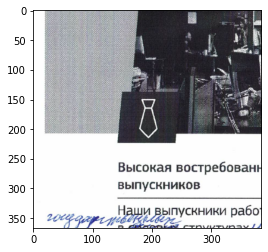

In [504]:
image = load_image(PATHS[0])
plt.imshow(image)
plt.show()

In [266]:
def central_crop_image(image, epsilon=0.1):
    TARGET_SIZE = tf.constant(100, dtype=tf.float32)

    image_size = tf.cast(tf.minimum(*image.shape[:2]), tf.float32)
    crop_fraction = tf.minimum((TARGET_SIZE / image_size)+epsilon, tf.constant(1, dtype=tf.float32))
    cropped_image = tf.image.central_crop(image, crop_fraction)
    return tf.image.resize(cropped_image, (TARGET_SIZE, TARGET_SIZE))

def get_central_crops(image, nums=10):
    eps = tf.linspace(start=0.1, stop=0.3, num=nums)
    crops = list()
    for epsilon in eps:
        crops.append(central_crop_image(image, epsilon).numpy())
    return crops

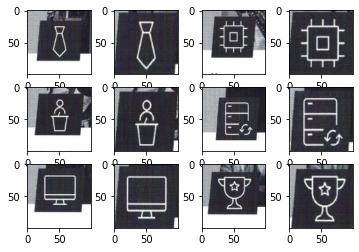

In [327]:
for i, path in enumerate(PATHS):
    img = load_image(path)
    img = central_crop_image(img)
    plt.subplot(3, 4, i+1)
    plt.imshow(img/255.)
plt.show()

In [528]:
class RandomSaturation(tf.keras.layers.experimental.preprocessing.PreprocessingLayer):
    def __init__(self, lower=0., upper=3.):
        super().__init__()
        self.lower = lower
        self.upper = upper

    def __call__(self, images):
        return tf.image.adjust_saturation(images, 
            tf.random.uniform((), minval=self.lower, maxval=self.upper))

class RandomBrightness(tf.keras.layers.experimental.preprocessing.PreprocessingLayer):
    def __init__(self, max_delta=0.4):
        super().__init__()
        self.max_delta = max_delta

    def __call__(self, images):
        return tf.image.adjust_brightness(images, 
            tf.random.uniform((), minval=-self.max_delta, maxval=self.max_delta))

data_augmentation = tf.keras.Sequential([
    RandomSaturation(),
    RandomBrightness(),
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.45),
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
])

In [499]:
def get_labeled_image(path):
    def get_label(path):
        str_label = tf.strings.split(path, sep=os.sep)[-2]
        return tf.strings.to_number(str_label, out_type=tf.int32)
    label = get_label(path)
    image = load_image(path)
    image = central_crop_image(image)
    return (image, label)

In [734]:
def get_data(paths, counts=100, split=False):

    def get_augmented_image(path):
        image, label = get_labeled_image(path)
        image = tf.reshape(image, (1, 100, 100, 3))
        image = data_augmentation(image)
        image = tf.reshape(image, (100, 100, 3))
        return [image, label]

    images = list()
    labels = list()
    data = list()

    paths = tf.repeat(paths, counts)
    size = len(paths)

    start_time = time.time()
    
    with ThreadPoolExecutor(8) as pool:
        data = list(pool.map(get_augmented_image, paths))

    for x, y in data:
        images.append(x)
        labels.append(y)

    tf.print("Loading data takes {:.3f}s".format(time.time()-start_time))

    if split:
        train_size = int(size*0.7)
        return (images[:train_size], labels[:train_size]), (images[train_size:], labels[train_size:])
    else:
        return images, labels

In [735]:
(train_images, train_labels), (test_images, test_labels) = get_data(PATHS, split=True)

Loading data takes 21.446s


In [736]:
len(train_images), len(train_labels), len(test_images), len(test_labels)

(840, 840, 360, 360)

In [737]:
dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
dataset = dataset.batch(4)
dataset

<BatchDataset shapes: ((None, 100, 100, 3), (None,)), types: (tf.float32, tf.int32)>

In [738]:
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_dataset = test_dataset.batch(10)

In [753]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer((100, 100, 3)),
    tf.keras.layers.Conv2D(filters=20, kernel_size=3, strides=1, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Conv2D(filters=10, kernel_size=3, strides=1, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Conv2D(filters=20, kernel_size=5, strides=5, padding='same', activation='tanh'),
    tf.keras.layers.MaxPool2D(5, 5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(7, activation='softmax'),
], name='ArtWayClass')

model.summary()

Model: "ArtWayClass"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_122 (Conv2D)          (None, 100, 100, 20)      560       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 50, 50, 20)        0         
_________________________________________________________________
conv2d_123 (Conv2D)          (None, 50, 50, 10)        1810      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 25, 25, 10)        0         
_________________________________________________________________
conv2d_124 (Conv2D)          (None, 5, 5, 20)          5020      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 1, 1, 20)          0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 20)                

In [754]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [743]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch == 0 or (epoch+1) % 1 == 0:
            tf.print('Epoch {:4d} - loss: {:.4f} - acc: {:.4f}, val_loss: {:.4f}, val_acc - {:.4f}'.format(
                epoch+1, logs['loss'], logs['accuracy'], logs['val_loss'], logs['val_accuracy']))

In [757]:
model.fit(
    dataset, 
    epochs=10, 
    validation_data=test_dataset,
    #callbacks=[CustomCallback()], 
    verbose=2)

Epoch 1/10
210/210 - 6s - loss: 1.5904 - accuracy: 0.1119 - val_loss: 4.3577 - val_accuracy: 0.0000e+00
Epoch 2/10
210/210 - 7s - loss: 1.5934 - accuracy: 0.1226 - val_loss: 4.4112 - val_accuracy: 0.0000e+00
Epoch 3/10
210/210 - 7s - loss: 1.5878 - accuracy: 0.1321 - val_loss: 4.4852 - val_accuracy: 0.0000e+00
Epoch 4/10
210/210 - 7s - loss: 1.5781 - accuracy: 0.1310 - val_loss: 4.5522 - val_accuracy: 0.0000e+00
Epoch 5/10
210/210 - 7s - loss: 1.5808 - accuracy: 0.1381 - val_loss: 4.6137 - val_accuracy: 0.0000e+00
Epoch 6/10


KeyboardInterrupt: 

In [758]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]